# 1) Bigrams & Trigrams (Frequency & Comparison)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Compute and compare frequent bigrams and trigrams from two works by the same author. All examples are running on Alice in wonderland and Alice through the looking glass books.
- Visualize both the most frequent phrases and those that are most distinctive for each work.

Learning objectives:
- Practice robust text preprocessing for Project Gutenberg texts (strip headers, normalize quotes, fix hyphenation). You should be able to modify these cleaning steps for your own use cases.
- Generate n-grams, compute normalized rates, and compare phrase distributions across texts.
- Produce reproducible CSV and PNG artifacts under `../results/` for reports or slides later.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words like "the" or "and".
3. Run cells from top to bottom. The main outputs are saved to `../results/`.

Prerequisites:
- A Python environment with requirements.txt requirements installed.
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook normalizes curly quotes and prunes single-letter tokens (except `a` and `i`) to avoid spurious n-grams like `alice q s`.
- If you see unexpected tokens, inspect where they are coming from in the raw text with some inspection cells and find your own solution to tackle the issue.

**Goal:** Compute frequent **bigrams** and **trigrams** for your two selected works, compare across books, and visualize the most characteristic phrases.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.
- Results are saved under `../results/`.


In [2]:

# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

# Adjust paths if your .txt files are not in ../data
CONFIG = {
    "book1_path": "../data/PetSemetary.txt",   # Pet Sematary
    "book2_path": "../data/TheShining.txt",    # The Shining
    "language": "en",
    "use_stopwords": True,
    "min_ngram_count": 5,
    "top_k": 20,
    "rate_base": 10000,

    "extra_stopwords": [
        # Pet Sematary characters
        "louis", "rachel", "gage", "ellie", "jud", "crandall", "creed",
        # The Shining characters / setting
        "jack", "wendy", "danny", "hallorann", "ullman", "overlook", "hotel",
        # Generic dialogue words you may want to ignore
        "said", "mister", "mrs", "mr"
    ]
}

# Unicode-aware token regex: words with optional internal ' or -
# Keeps contractions (don't) and hyphenated compounds (well-known).
# Excludes digits and underscores.
WORD_RE = re.compile(
    r"[^\W\d_]+(?:[-'\u2019][^\W\d_]+)*",
    flags=re.UNICODE
)

# ===== Stopwords (spaCy if available, else small fallback) =====
try:
    import spacy
    from spacy.lang.en.stop_words import STOP_WORDS as _spacy_stop
    STOPWORDS = {w.lower() for w in _spacy_stop}
    stop_source = "spacy"
except Exception:
    STOPWORDS = {
        "the","and","to","of","a","in","it","is","that","i","you","he","she",
        "they","we","was","for","on","with","as","at","by","an"
    }
    stop_source = "fallback"

EXTRA = set(CONFIG.get("extra_stopwords", []))
EXTRA = {x.lower() for x in EXTRA}
EXTRA |= {"said"}
STOPWORDS |= EXTRA

## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.



In [3]:
def load_text(path: str) -> str:
    """Read text file as UTF-8 (ignoring errors)."""
    return Path(path).read_text(encoding="utf-8", errors="ignore")

def normalize_text(t: str) -> str:
    """
    Basic normalization:
    - normalize curly quotes to ASCII '
    - join hyphenated line breaks (won-\nderful -> wonderful)
    - normalize whitespace
    """
    # curly apostrophes -> normal apostrophe
    t = t.replace("’", "'").replace("‘", "'")

    # join hyphen + line break
    t = re.sub(r"-\s*\n", "", t)

    # normalize whitespace
    t = re.sub(r"\s+", " ", t)

    return t

# Load + normalize two books
text1_raw = load_text(CONFIG["book1_path"])  # Pet Sematary
text2_raw = load_text(CONFIG["book2_path"])  # The Shining

text1 = normalize_text(text1_raw)
text2 = normalize_text(text2_raw)

# Lowercase + tokenize using WORD_RE
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

# Optional stopword + 1-letter pruning (keep "a" and "i")
if CONFIG["use_stopwords"]:
    def filter_tokens(ts):
        out = []
        for t in ts:
            if len(t) == 1 and t not in {"a", "i"}:
                continue
            if t in STOPWORDS:
                continue
            out.append(t)
        return out

    tokens1 = filter_tokens(tokens1)
    tokens2 = filter_tokens(tokens2)

# Combined tokens
tokens = tokens1 + tokens2

print("Token counts:")
print("Pet Sematary:", len(tokens1))
print("The Shining :", len(tokens2))
print("Combined    :", len(tokens))

Token counts:
Pet Sematary: 96911
The Shining : 107915
Combined    : 204826


In [4]:
def load_text(path: str) -> str:
    """Read text file as UTF-8 (ignoring errors)."""
    return Path(path).read_text(encoding="utf-8", errors="ignore")

def normalize_text(t: str) -> str:
    """
    Basic normalization:
    - normalize curly quotes to ASCII '
    - join hyphenated line breaks (won-\nderful -> wonderful)
    - normalize whitespace
    """
    # curly apostrophes -> normal apostrophe
    t = t.replace("’", "'").replace("‘", "'")

    # join hyphen + line break
    t = re.sub(r"-\s*\n", "", t)

    # normalize whitespace
    t = re.sub(r"\s+", " ", t)

    return t

# Load + normalize two books
text1_raw = load_text(CONFIG["book1_path"])  # Pet Sematary
text2_raw = load_text(CONFIG["book2_path"])  # The Shining

text1 = normalize_text(text1_raw)
text2 = normalize_text(text2_raw)

# Lowercase + tokenize using WORD_RE
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

# Optional stopword + 1-letter pruning (keep "a" and "i")
if CONFIG["use_stopwords"]:
    def filter_tokens(ts):
        out = []
        for t in ts:
            if len(t) == 1 and t not in {"a", "i"}:
                continue
            if t in STOPWORDS:
                continue
            out.append(t)
        return out

    tokens1 = filter_tokens(tokens1)
    tokens2 = filter_tokens(tokens2)

# Combined tokens
tokens = tokens1 + tokens2

print("Token counts:")
print("Pet Sematary:", len(tokens1))
print("The Shining :", len(tokens2))
print("Combined    :", len(tokens))

Token counts:
Pet Sematary: 96911
The Shining : 107915
Combined    : 204826


In [5]:
from itertools import tee, islice

def ngrams(seq, n=2):
    """Return an iterator of n-grams from sequence `seq`."""
    iters = tee(seq, n)
    for i, it in enumerate(iters):
        next(islice(it, i, i), None)
    return zip(*iters)

def freq_table(tokens, n=2, min_count=1, rate_base=10000, top_k=20):
    """
    Compute n-gram frequencies for a list of tokens.

    Returns:
      df: DataFrame with ['ngram','count','rate_per_X']
      ng: Counter of all n-grams
      total: total n-grams
    """
    ng = Counter(ngrams(tokens, n))
    total = sum(ng.values())
    rows = []
    for gram, c in ng.items():
        if c >= min_count:
            rows.append({
                "ngram": " ".join(gram),
                "count": c,
                "rate_per_%d" % rate_base: (c / max(1, total)) * rate_base
            })
    df = (
        pd.DataFrame(rows)
        .sort_values(["count", "ngram"], ascending=[False, True])
        .head(top_k)
    )
    return df, ng, total


In [6]:
min_c = CONFIG["min_ngram_count"]
top_k = CONFIG["top_k"]
rate_base = CONFIG["rate_base"]

# Combined bigrams
bi_df, bi_counts, bi_total = freq_table(
    tokens,
    n=2,
    min_count=min_c,
    rate_base=rate_base,
    top_k=top_k
)

# Book-level bigrams
bi_df_1, bi_counts_1, bi_total_1 = freq_table(
    tokens1,
    n=2,
    min_count=min_c,
    rate_base=rate_base,
    top_k=top_k
)
bi_df_2, bi_counts_2, bi_total_2 = freq_table(
    tokens2,
    n=2,
    min_count=min_c,
    rate_base=rate_base,
    top_k=top_k
)

print("\nTop combined bigrams:")
display(bi_df.head(10))



Top combined bigrams:


,ngram,count,rate_per_10000
157,had been,760,37.104846
225,would be,218,10.643232
850,his eyes,170,8.299768
608,would have,165,8.055657
279,all right,161,7.860369
72,his head,161,7.860369
60,his own,142,6.932747
150,have been,136,6.639814
134,did not,129,6.298059
328,his face,128,6.249237


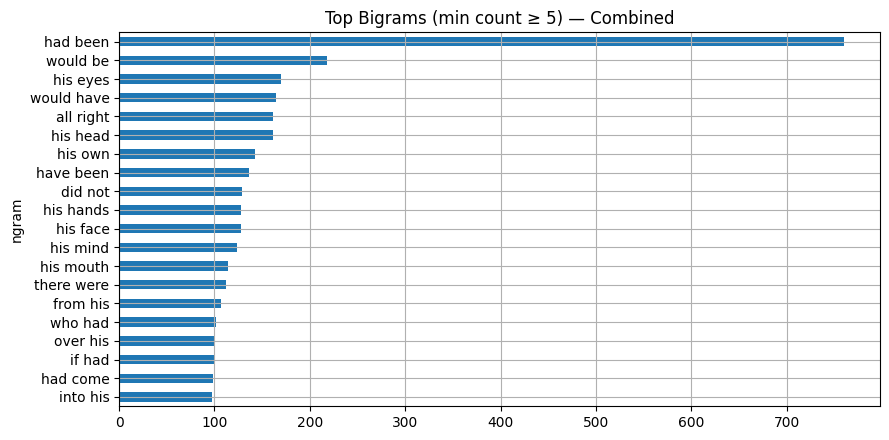


Distinctive bigrams – Pet Sematary (Book 1):


,ngram,count_b1,rate_b1,count_b2,rate_b2,rate_diff_b1_minus_b2,rate_diff_b2_minus_b1
2,did not,94.0,9.699721,0.0,0.000000,9.699721,-9.699721
21,pet sematary,66.0,6.810443,0.0,0.000000,6.810443,-6.810443
17,if had,56.0,5.778557,0.0,0.000000,5.778557,-5.778557
24,who had,56.0,5.778557,0.0,0.000000,5.778557,-5.778557
1,could have,55.0,5.675369,0.0,0.000000,5.675369,-5.675369
23,up there,51.0,5.262615,0.0,0.000000,5.262615,-5.262615
6,had gone,47.0,4.849861,0.0,0.000000,4.849861,-4.849861
26,would have,99.0,10.215664,66.0,6.115981,4.099683,-4.099683
14,his mind,71.0,7.326385,53.0,4.911318,2.415067,-2.415067
7,have been,76.0,7.842328,60.0,5.559983,2.282345,-2.282345



Distinctive bigrams – The Shining (Book 2):


,ngram,count_b1,rate_b1,count_b2,rate_b2,rate_diff_b1_minus_b2,rate_diff_b2_minus_b1
4,had been,317.0,32.710763,443.0,41.051207,-8.340445,8.340445
3,from his,0.0,0.000000,69.0,6.393980,-6.393980,6.393980
20,over his,0.0,0.000000,64.0,5.930648,-5.930648,5.930648
5,had come,0.0,0.000000,63.0,5.837982,-5.837982,5.837982
11,his hand,0.0,0.000000,57.0,5.281984,-5.281984,5.281984
19,out his,0.0,0.000000,55.0,5.096651,-5.096651,5.096651
10,his father,0.0,0.000000,52.0,4.818652,-4.818652,4.818652
18,into his,0.0,0.000000,52.0,4.818652,-4.818652,4.818652
25,would be,87.0,8.977402,131.0,12.139296,-3.161894,3.161894
13,his head,62.0,6.397689,99.0,9.173972,-2.776283,2.776283


In [7]:
ax = bi_df.sort_values("count").plot.barh(
    x="ngram",
    y="count",
    legend=False
)
ax.set_title(f"Top Bigrams (min count ≥ {min_c}) — Combined")
fig_combined = ax.get_figure()
plt.tight_layout()
plt.show()


# =====================================
# 3.2 Distinctive Bigrams per Book
# =====================================
key = "rate_per_%d" % rate_base
df1 = bi_df_1.rename(columns={"count": "count_b1", key: "rate_b1"})
df2 = bi_df_2.rename(columns={"count": "count_b2", key: "rate_b2"})

m = pd.merge(
    df1[["ngram", "count_b1", "rate_b1"]],
    df2[["ngram", "count_b2", "rate_b2"]],
    on="ngram",
    how="outer"
).fillna(0)

m["rate_diff_b1_minus_b2"] = m["rate_b1"] - m["rate_b2"]
m["rate_diff_b2_minus_b1"] = -m["rate_diff_b1_minus_b2"]

top_b1 = m.sort_values("rate_diff_b1_minus_b2", ascending=False).head(top_k)
top_b2 = m.sort_values("rate_diff_b2_minus_b1", ascending=False).head(top_k)

print("\nDistinctive bigrams – Pet Sematary (Book 1):")
display(top_b1.head(10))
print("\nDistinctive bigrams – The Shining (Book 2):")
display(top_b2.head(10))



Distinctive bigrams – Pet Sematary (Book 1):


,ngram,count_b1,rate_b1,count_b2,rate_b2,rate_diff_b1_minus_b2,rate_diff_b2_minus_b1
2,did not,94.0,9.699721,0.0,0.000000,9.699721,-9.699721
21,pet sematary,66.0,6.810443,0.0,0.000000,6.810443,-6.810443
17,if had,56.0,5.778557,0.0,0.000000,5.778557,-5.778557
24,who had,56.0,5.778557,0.0,0.000000,5.778557,-5.778557
1,could have,55.0,5.675369,0.0,0.000000,5.675369,-5.675369
23,up there,51.0,5.262615,0.0,0.000000,5.262615,-5.262615
6,had gone,47.0,4.849861,0.0,0.000000,4.849861,-4.849861
26,would have,99.0,10.215664,66.0,6.115981,4.099683,-4.099683
14,his mind,71.0,7.326385,53.0,4.911318,2.415067,-2.415067
7,have been,76.0,7.842328,60.0,5.559983,2.282345,-2.282345



Distinctive bigrams – The Shining (Book 2):


,ngram,count_b1,rate_b1,count_b2,rate_b2,rate_diff_b1_minus_b2,rate_diff_b2_minus_b1
4,had been,317.0,32.710763,443.0,41.051207,-8.340445,8.340445
3,from his,0.0,0.000000,69.0,6.393980,-6.393980,6.393980
20,over his,0.0,0.000000,64.0,5.930648,-5.930648,5.930648
5,had come,0.0,0.000000,63.0,5.837982,-5.837982,5.837982
11,his hand,0.0,0.000000,57.0,5.281984,-5.281984,5.281984
19,out his,0.0,0.000000,55.0,5.096651,-5.096651,5.096651
10,his father,0.0,0.000000,52.0,4.818652,-4.818652,4.818652
18,into his,0.0,0.000000,52.0,4.818652,-4.818652,4.818652
25,would be,87.0,8.977402,131.0,12.139296,-3.161894,3.161894
13,his head,62.0,6.397689,99.0,9.173972,-2.776283,2.776283


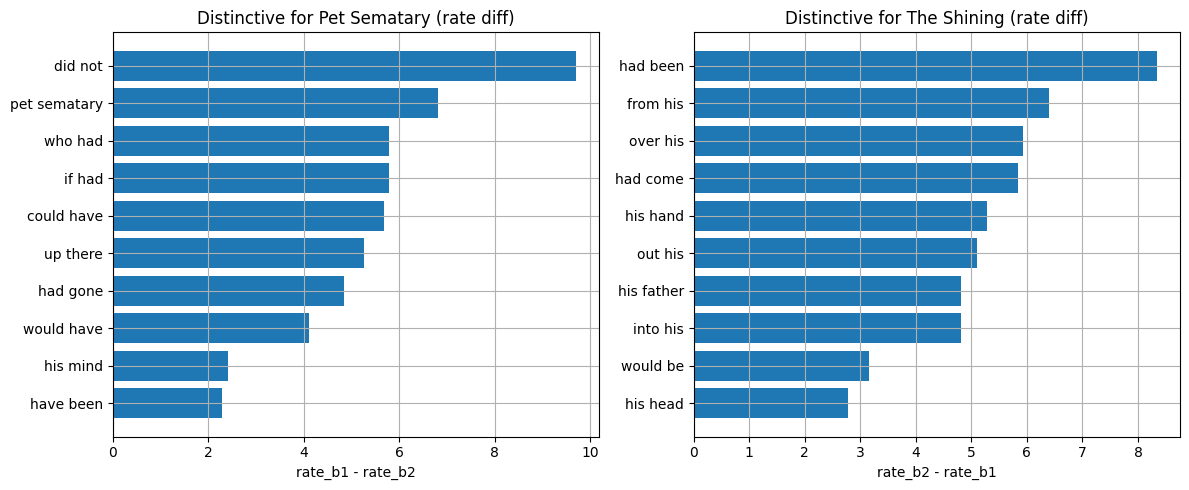

In [8]:
key = "rate_per_%d" % rate_base
df1 = bi_df_1.rename(columns={"count": "count_b1", key: "rate_b1"})
df2 = bi_df_2.rename(columns={"count": "count_b2", key: "rate_b2"})

m = pd.merge(
    df1[["ngram", "count_b1", "rate_b1"]],
    df2[["ngram", "count_b2", "rate_b2"]],
    on="ngram",
    how="outer"
).fillna(0)

m["rate_diff_b1_minus_b2"] = m["rate_b1"] - m["rate_b2"]
m["rate_diff_b2_minus_b1"] = -m["rate_diff_b1_minus_b2"]

top_b1 = m.sort_values("rate_diff_b1_minus_b2", ascending=False).head(top_k)
top_b2 = m.sort_values("rate_diff_b2_minus_b1", ascending=False).head(top_k)

print("\nDistinctive bigrams – Pet Sematary (Book 1):")
display(top_b1.head(10))
print("\nDistinctive bigrams – The Shining (Book 2):")
display(top_b2.head(10))

# =====================================
# 3.3 Visualize Distinctive Bigrams
# =====================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

top_b1_plot = top_b1.sort_values("rate_diff_b1_minus_b2").tail(10)
axes[0].barh(top_b1_plot["ngram"], top_b1_plot["rate_diff_b1_minus_b2"])
axes[0].set_title("Distinctive for Pet Sematary (rate diff)")
axes[0].set_xlabel("rate_b1 - rate_b2")

top_b2_plot = top_b2.sort_values("rate_diff_b2_minus_b1").tail(10)
axes[1].barh(top_b2_plot["ngram"], top_b2_plot["rate_diff_b2_minus_b1"])
axes[1].set_title("Distinctive for The Shining (rate diff)")
axes[1].set_xlabel("rate_b2 - rate_b1")

fig_distinctive = fig
plt.tight_layout()
plt.show()


Top combined trigrams:


,ngram,count,rate_per_10000
35,there had been,55,2.685232
57,over his shoulder,31,1.513495
49,no more than,28,1.367027
31,shook his head,26,1.269382
65,would have been,26,1.269382
167,if had been,23,1.122915
0,micmac burying ground,23,1.122915
25,must have been,23,1.122915
15,there would be,23,1.122915
53,but did not,22,1.074093


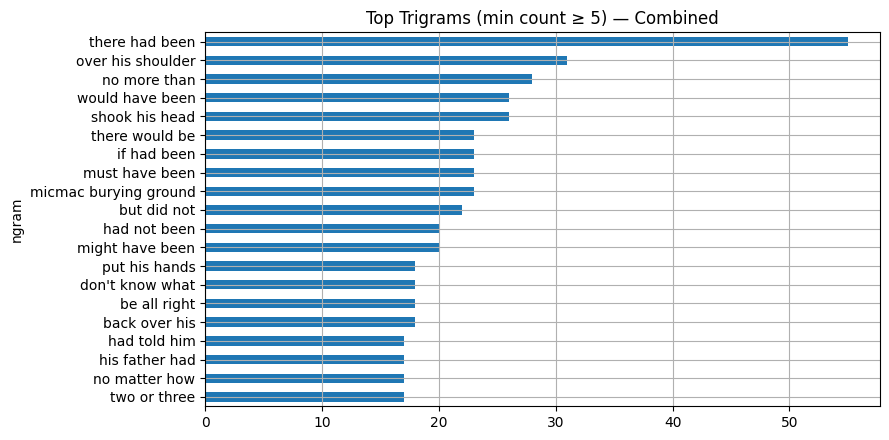


Top 4-grams (min count ≥ 2):


,ngram,count,rate_per_10000
70,back over his shoulder,18,0.878808
159,grows what can tends,8,0.390581
158,man grows what can,8,0.390581
157,soil man's heart stonier,8,0.390581
211,there had been no,8,0.390581
580,looked back over his,7,0.341758
680,timmy baterman had been,7,0.341758
590,had no idea how,6,0.292936
1116,handkerchief out his back,6,0.292936
1115,his handkerchief out his,6,0.292936


In [9]:
# =====================================
# 4. Trigram Frequency (Combined)
# =====================================
tri_df, tri_counts, tri_total = freq_table(
    tokens,
    n=3,
    min_count=min_c,
    rate_base=rate_base,
    top_k=top_k
)

print("\nTop combined trigrams:")
display(tri_df.head(10))

# 4.1 Plot Top Trigrams (Combined)
ax = tri_df.sort_values("count").plot.barh(
    x="ngram",
    y="count",
    legend=False
)
ax.set_title(f"Top Trigrams (min count ≥ {min_c}) — Combined")
fig_tri = ax.get_figure()
plt.tight_layout()
plt.show()


# =====================================
# 5. Optional: 4-grams (for curiosity)
# =====================================
n_df, n_counts, n_total = freq_table(
    tokens,
    n=4,
    min_count=2,
    rate_base=rate_base,
    top_k=top_k
)

print("\nTop 4-grams (min count ≥ 2):")
display(n_df.head(10))

In [10]:
# Save tables
bi_df.to_csv("../results/bigrams_combined.csv", index=False)
bi_df_1.to_csv("../results/bigrams_book1.csv", index=False)
bi_df_2.to_csv("../results/bigrams_book2.csv", index=False)
tri_df.to_csv("../results/trigrams_combined.csv", index=False)
n_df.to_csv("../results/fourgrams_combined.csv", index=False)

# Save figures
try:
    fig_combined.savefig(
        "../results/bigrams_plot.png", dpi=200, bbox_inches="tight"
    )
except Exception:
    pass

try:
    fig_distinctive.savefig(
        "../results/distinctive_bigrams_plot.png", dpi=200, bbox_inches="tight"
    )
except Exception:
    pass

try:
    fig_tri.savefig(
        "../results/trigrams_plot.png", dpi=200, bbox_inches="tight"
    )
except Exception:
    pass

print("\nSaved CSVs and PNGs into ../results/")


Saved CSVs and PNGs into ../results/
